Total confirmed, dead, and recovered numbers in the world, respectively:  2240190 153821 568343
      status    count      upper
0     active  1518026  confirmed
1     deaths   153821  confirmed
2  recovered   568343  confirmed


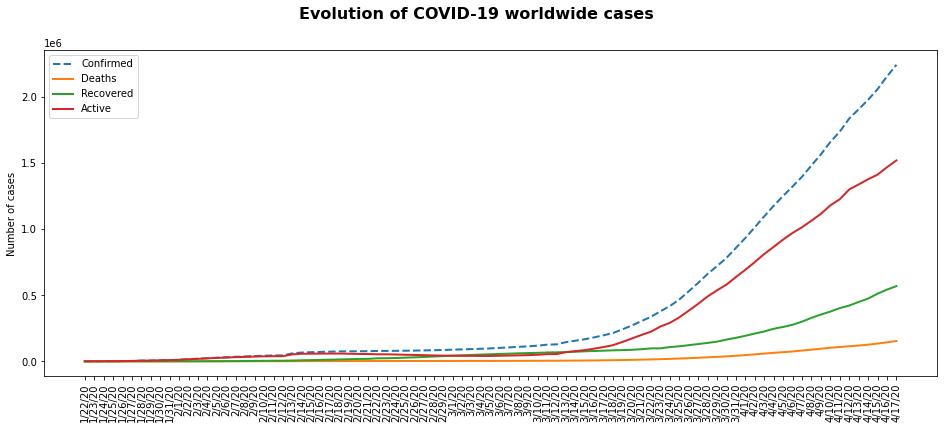

(76, 90)


'temp-plot.html'

In [1]:
import numpy as np # math
import pandas as pd # data hanlding
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker # chart
import seaborn as sns # dynamic 
import plotly.express as px
from plotly.offline import plot  #To plot in Spyder IDE. Opens plots in the default browser


# source: can be Excel, CSV, PDF, SQL, MYSql, SqlLite, Oracle, JSON etc  PostSQL. office server :website

covid_confirmed   = pd.read_csv.('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
covid_confirmed.to_csv("yourpath","urfilename.csv")
covid_deaths = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
covid_recovered = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
#print(covid_confirmed.head())

#print(covid_confirmed.shape)
#print(covid_deaths.shape)
#print(covid_recovered.shape)

#Rename to consistent values
covid_confirmed['Country/Region'].replace('Mainland China', 'China', inplace=True)
covid_deaths['Country/Region'].replace('Mainland China', 'China', inplace=True)
covid_recovered['Country/Region'].replace('Mainland China', 'China', inplace=True)

#Handle empty data
covid_confirmed[['Province/State']] = covid_confirmed[['Province/State']].fillna('')
covid_confirmed.fillna(0, inplace=True)
covid_deaths[['Province/State']] = covid_deaths[['Province/State']].fillna('')
covid_deaths.fillna(0, inplace=True)
covid_recovered[['Province/State']] = covid_recovered[['Province/State']].fillna('')
covid_recovered.fillna(0, inplace=True)

#print(covid_confirmed.isna().sum().sum())
#print(covid_deaths.isna().sum().sum())
#print(covid_recovered.isna().sum().sum())

##################################################################
#
#Snapshot as of today.
#Start by aggregating all the cases to see a snapshot for the world.
covid_confirmed_count = covid_confirmed.iloc[:, 4:].sum().max()
covid_deaths_count = covid_deaths.iloc[:, 4:].sum().max()
covid_recovered_count = covid_recovered.iloc[:, 4:].sum().max()

print('Total confirmed, dead, and recovered numbers in the world, respectively: ', 
     covid_confirmed_count, covid_deaths_count, covid_recovered_count)

#For easy plotting let us store all these numbers in a dataframe. 
#Let us also calculate active cases.
#Active=Confirmed−Deaths−Recovered

world_df = pd.DataFrame({
    'confirmed': [covid_confirmed_count],
    'deaths': [covid_deaths_count],
    'recovered': [covid_recovered_count],
    'active': [covid_confirmed_count - covid_deaths_count - covid_recovered_count]
})

#print(world_df)

#Unpivot the DataFrame from wide to long format
world_long_df = world_df.melt(value_vars=['active', 'deaths', 'recovered'],
                              var_name="status",
                              value_name="count")

world_long_df['upper'] = 'confirmed'

print(world_long_df)

fig = px.treemap(world_long_df, path=["status"], values="count",
                 color_discrete_sequence=['#3498db', '#2ecc71', '#e74c3c'],
                 template='plotly_dark')

plot(fig) #For Spyder IDE. Opens plots in default IDE

#Summary: as of 27th March. Most cases are still active.

##################################################################

#Evolution of virus cases over time

#Remove first 4 columns about state, country, etc. and sum numbers for all dates
covid_worldwide_confirmed = covid_confirmed.iloc[:, 4:].sum(axis=0)
covid_worldwide_deaths = covid_deaths.iloc[:, 4:].sum(axis=0)
covid_worldwide_recovered = covid_recovered.iloc[:, 4:].sum(axis=0)
covid_worldwide_active = covid_worldwide_confirmed - covid_worldwide_deaths - covid_worldwide_recovered

#print(covid_worldwide_confirmed.head())
#print(covid_worldwide_deaths.head())
#print(covid_worldwide_recovered.head())
#print(covid_worldwide_active.head())

#Use Seaborn for plotting
fig, ax = plt.subplots(figsize=(16, 6))

sns.lineplot(x=covid_worldwide_confirmed.index, y=covid_worldwide_confirmed, sort=False, linewidth=2)
sns.lineplot(x=covid_worldwide_deaths.index, y=covid_worldwide_deaths, sort=False, linewidth=2)
sns.lineplot(x=covid_worldwide_recovered.index, y=covid_worldwide_recovered, sort=False, linewidth=2)
sns.lineplot(x=covid_worldwide_active.index, y=covid_worldwide_active, sort=False, linewidth=2)

ax.lines[0].set_linestyle("--")  #Plot Confirmed cases in dashed lines

plt.suptitle("Evolution of COVID-19 worldwide cases", fontsize=16, fontweight='bold', color='black')

plt.xticks(rotation=90)
plt.ylabel('Number of cases')

ax.legend(['Confirmed', 'Deaths', 'Recovered', 'Active'])

plt.show()



#Evolution of Mortality rate 
#Create a new data frame to capture all the numbers for confirmed, recovered, active, death.
world_rate_df = pd.DataFrame({
    'confirmed': covid_worldwide_confirmed,
    'deaths': covid_worldwide_deaths,
    'recovered': covid_worldwide_recovered,
    'active': covid_worldwide_active
}, index=covid_worldwide_confirmed.index)

#print(world_rate_df.tail())

#Calculate recovery and mortality rate as a fraction of confirmed
world_rate_df['recovery rate'] = world_rate_df['recovered'] / world_rate_df['confirmed'] * 100
world_rate_df['mortality rate'] = world_rate_df['deaths'] / world_rate_df['confirmed'] * 100
world_rate_df['date'] = world_rate_df.index

#print(world_rate_df.tail())

#Unpivot the DataFrame from wide to long format
world_rate_long_df = world_rate_df.melt(id_vars="date",
                                        value_vars=['recovery rate', 'mortality rate'],
                                        var_name="status",
                                        value_name="ratio")

#print(world_rate_long_df)

#USe plotly to plot the numbers
fig = px.line(world_rate_long_df, x="date", y="ratio", color='status', log_y=True, 
              title='Recovery and Mortality rate over the time',
              color_discrete_sequence=['#2ecc71', '#e74c3c'],
              template='plotly_dark')

plot(fig)

#Summary: As of 27th March the recovery rate is falling and mortality rate is increasing.

#################################################################################
#Plotting data onto a map using latitude and longitude values
#Takes a bit of time based on the number of countries. 
#Group rows that contain same Country/Region values. 
#We will use sum to add all values while grouping.
covid_confirmed_agg = covid_confirmed.groupby('Country/Region').sum().reset_index()

#Data for some countries is broken down into states/provinces. 
#So we need to calculate mean latitude and longitude
covid_confirmed_agg.loc[:, ['Lat', 'Long']] = covid_confirmed.groupby('Country/Region').mean().reset_index().loc[:, ['Lat', 'Long']]
#print(covid_confirmed_agg)

#Since there are a lot of countries, for easy visualization let us only look at countries with high numbers
MIN_CASES = 1000
covid_confirmed_agg = covid_confirmed_agg[covid_confirmed_agg.iloc[:, 3:].max(axis=1) > MIN_CASES]
print(covid_confirmed_agg.shape)
#print(covid_confirmed_agg.head())

#Unpivot the DataFrame from wide to long format
covid_confirmed_agg_long = pd.melt(covid_confirmed_agg,
                                   id_vars=covid_confirmed_agg.iloc[:, :3],
                                   var_name='date',
                                   value_vars=covid_confirmed_agg.iloc[:, 3:],
                                   value_name='date_confirmed_cases')
#print(covid_confirmed_agg_long.shape)

#Plotly for visualization.
fig = px.scatter_geo(covid_confirmed_agg_long,
                     lat="Lat", lon="Long", color="Country/Region",
                     hover_name="Country/Region", size="date_confirmed_cases",
                     size_max=50, animation_frame="date",
                     template='plotly_dark', projection="natural earth",
                     title="COVID-19 worldwide confirmed cases over time_Abhisheak")

plot(fig)

In [ ]:
# 122 >> DOS (C,C++)

122 candidates are comple